# Experiment 2

The aim of this experiment is to understand if there is a linear relationship between one frame and the next k frames. We want to understand what is the maximum value of k for which the linear relationship stops being a good prediction.

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# import functions
import sys
sys.path.insert(0, '../')
from my_functions import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

## Read data

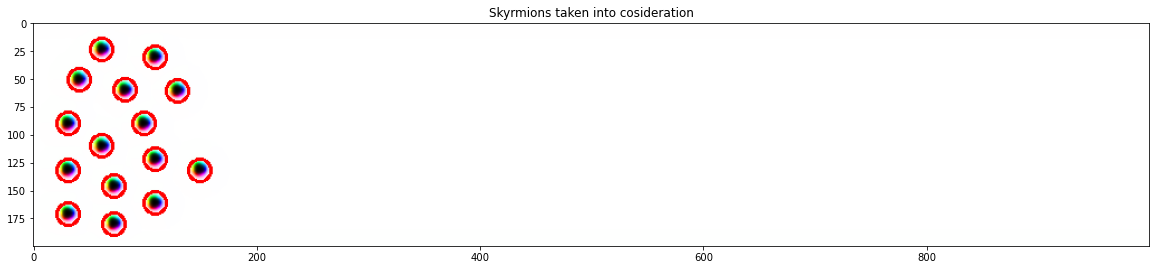

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 124.41it/s]


In [2]:
data = pd.read_csv('../../data/processed/trajectories.csv')

# show which particles we will be working on
show_tracked(data, '../../data/raw/')

# get list of frames, each item in the list is another list containing the x, y coordinates
# for each skyrmion in order, i.e. [x_0, y_0, x_1, y_1, ...]
frames = get_frames(data)

In [3]:
def preprocess(frames, k=1):
    # data in format (frame, next k frames)
    df = pd.DataFrame(columns=['X', 'y'])

    for i in range(k, len(frames)):
        target = []
        for j in range(k-1, -1, -1):
            target = target + frames[i-j]
        df = df.append({'X': frames[i-k], 'y': target}, ignore_index=True)
    return df

In [4]:
def plot(pred_train, pred_test, i=0, ids=[0]):
    pred_train_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])
    pred_test_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])

    # for every frame from the ith
    for f in range(k):
        # for every particle in each frame
        for p in range(0, len(pred_train[i, f]), 2):
            pred_train_df = pred_train_df.append({'x': pred_train[i, f, p], 'y': pred_train[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)

    # for every frame from the ith
    for f in range(k):
        # for every particle in each frame
        for p in range(0, len(pred_test[i, f]), 2):
            pred_test_df = pred_test_df.append({'x': pred_test[i, f, p], 'y': pred_test[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)
            
    truth_df = data.loc[(data['frame'] > i) & (data['frame'] <= i+k)]
    plot_prediction(truth_df, pred_train_df, ids=ids)
    
    truth_df = data.loc[(data['frame'] > i+split_idx) & (data['frame'] <= i+k+split_idx)]
    plot_prediction(truth_df, pred_test_df, ids=ids)

In [58]:
k = 3
df = preprocess(frames, k)

In [59]:
# split data in training and testing using 20% for testing
split_pct = 0.2
split_idx = df.index.values[-int(split_pct*max(df.index.values))]
X_train, y_train, X_test, y_test = split(df, split_pct)

## Linear Regression

In [60]:
# build and fit the model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# evaluate the model
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.945566660026862
R2 score is 0.979935899871649


The model performance for X_test
--------------------------------------
RMSE is 8.508833669270901
R2 score is 0.6540627982483557




In [61]:
pred_train = y_predict_train.reshape((y_predict_train.shape[0], k, -1))
pred_test = y_predict_test.reshape((y_predict_test.shape[0], k, -1))

***Plots for prediction on training set and test set***


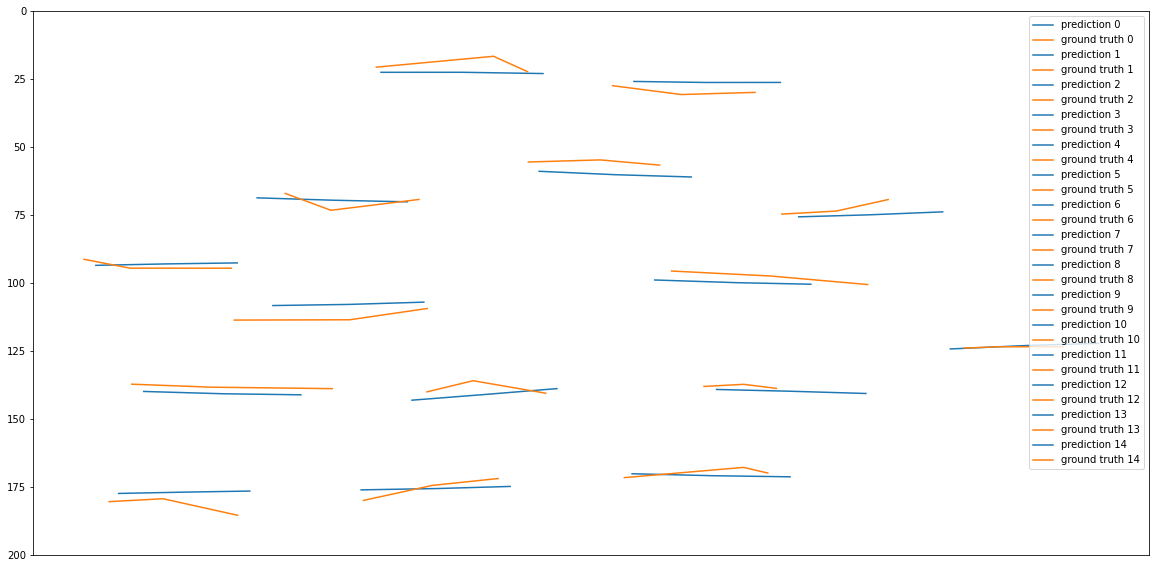

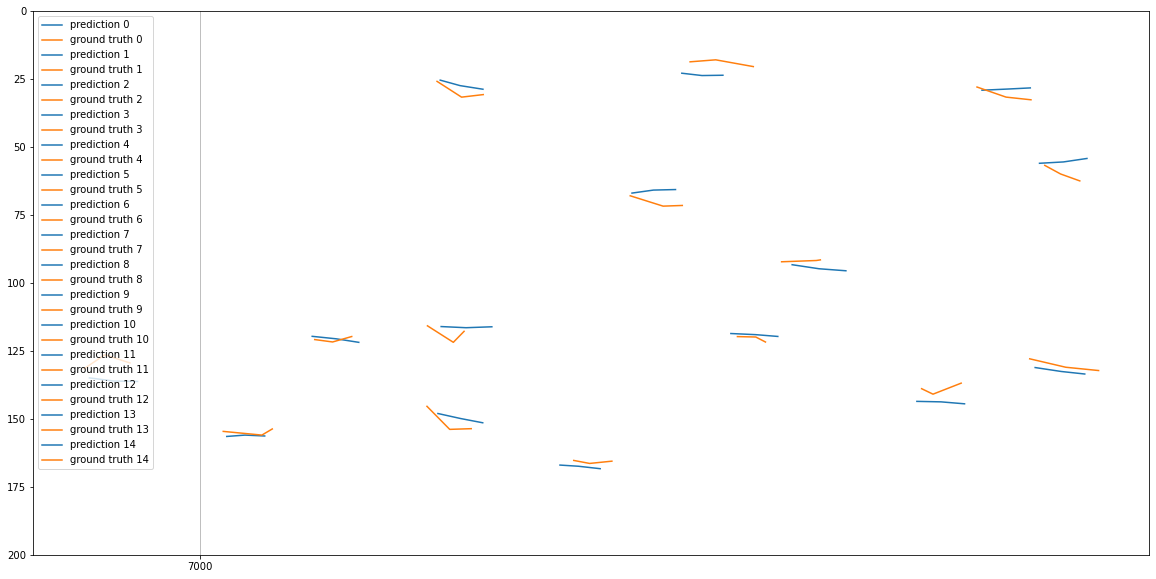

In [63]:
print('***Plots for prediction on training set and test set***')
plot(pred_train, pred_test, 10, list(range(15)))

The reason why the segments in the test plot are much shorter is because the x-axis on the two plots do not have the same scale. That is because on the training set (expecially at the beginning), the particles are all close to each other, hence making it possible to plot all the predictions on a smaller range on the x-axis, but on the test set the particles are further from each other since they are further in the future in the simulation.

## Save models

In [32]:
filename = '../../models/regression_2_linear.sav'
pickle.dump(lin_model, open(filename, 'wb'))

## What is the max k for linearity?

In [46]:
for k in range(1, 10):
    print('***** k = ' + str(k) + ' *****')
    df = preprocess(frames, k)
    
    # split data in training and testing using 20% for testing
    split_pct = 0.2
    split_idx = df.index.values[-int(split_pct*max(df.index.values))]
    X_train, y_train, X_test, y_test = split(df, split_pct)
    
    # build and fit the model
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)

    # evaluate the model
    print('The model performance for X_train')
    y_predict_train = evaluate(X_train, y_train, lin_model)

    print('The model performance for X_test')
    y_predict_test = evaluate(X_test, y_test, lin_model)

***** k = 1 *****
The model performance for X_train
--------------------------------------
RMSE is 3.416191282758604
R2 score is 0.9854093671582872


The model performance for X_test
--------------------------------------
RMSE is 5.964209454235747
R2 score is 0.8295229850253383


***** k = 2 *****
The model performance for X_train
--------------------------------------
RMSE is 3.6999887316266276
R2 score is 0.9825840373111144


The model performance for X_test
--------------------------------------
RMSE is 7.170931264634444
R2 score is 0.7539869314756348


***** k = 3 *****
The model performance for X_train
--------------------------------------
RMSE is 3.945566660026862
R2 score is 0.979935899871649


The model performance for X_test
--------------------------------------
RMSE is 8.508833669270901
R2 score is 0.6540627982483557


***** k = 4 *****
The model performance for X_train
--------------------------------------
RMSE is 4.153520287300575
R2 score is 0.9775818005329567


The mod

## Observations

We can see that for n > 3, the RMSE is close to 10.0 and the R2 score < 0.6, which means that the model does not capture the variance of the data well enough.